In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "4"  # Set the GPU 2 to use

In [2]:
import sys

sys.path.append('../GSL')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

import os
from glob import glob, escape
import torch.nn as nn
from torch.nn import functional as F

import pickle
import yaml
from easydict import EasyDict as edict

from torch_geometric.utils import to_dense_adj, dense_to_sparse, add_self_loops

In [4]:
from utils.scalers import *
from utils.score import *

In [5]:
country = ['US','Canada','Mexico','Russia',
           'United Kingdom','Italy','Germany','France',
           'Belarus','Brazil','Peru','Ecuador',
           'Chile','India','Turkey','Saudi Arabia',
           'Pakistan','Iran','Singapore','Qatar',
           'Bangladesh','United Arab Emirates','China','Japan','Korea, South']
country.sort()

In [103]:
# exp_dirs = glob('../exp/COVID_PN_BEATS/Random_Graph/*')
exp_dirs = glob('../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/*')
exp_dirs.sort()

In [104]:
exp_dirs

['../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS',
 '../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/graph_learning_GTS__stacks_3__singular_stack_num_1__mlp_stack_1024_0722_182720',
 '../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/graph_learning_GTS__stacks_6__singular_stack_num_1__mlp_stack_1024_0722_183156',
 '../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/graph_learning_GTS__stacks_9__singular_stack_num_1__mlp_stack_1024_0722_184133',
 '../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/graph_learning_MTGNN__stacks_3__singular_stack_num_1__mlp_stack_1024_0722_182743',
 '../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/graph_learning_MTGNN__stacks_6__singular_stack_num_1__mlp_stack_1024_0722_183232',
 '../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/graph_learning_MTGNN__stacks_9__singular_stack_num_1__mlp_stack_1024_0722_185701',
 '../exp

In [105]:
loss_list = []

for exp in exp_dirs:
    test_result_dirs = glob(escape(exp+'/test_result.pickle'))
    if len(test_result_dirs) == 0:
        loss = 100
    else:    
        test_result = pickle.load(open(test_result_dirs[0], 'rb'))
        loss = test_result['score']['inv_scaled_score']['MAPE']
    
    loss_list.append(loss)
    
loss_list = np.array(loss_list)

In [106]:
loss_list

array([100.        ,   0.91862231,   0.84042412,   0.95947558,
         0.76338571,   0.96109211,   0.92182648,   0.68682891,
         0.84639275,   0.86121339])

In [107]:
exp = exp_dirs[np.argmin(loss_list)]
# exp = exp_dirs[0]

In [108]:
exp

'../exp/COVID_PN_BEATS/Graph_Learning/COVID_PN_BEATS/Graph_Learning/graph_learning_attention__stacks_3__singular_stack_num_1__mlp_stack_1024_0722_182703'

In [109]:
config_file = glob(escape(exp+'/config.yaml'))[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

train_result_dirs = glob(escape(exp+'/training_result.pickle'))
train_result = pickle.load(open(train_result_dirs[0], 'rb'))

test_result_dirs = glob(escape(exp+'/test_result.pickle'))
test_result = pickle.load(open(test_result_dirs[0], 'rb'))

In [110]:
test_result['score']

{'scaled_score': {'MAE': 0.49919948,
  'MAPE': 1.0730046,
  'RMSE': 0.7839051626075105,
  'MSE': 0.6144973},
 'inv_scaled_score': {'MAE': 900.33044,
  'MAPE': 0.6868289,
  'RMSE': 2534.838850895654,
  'MSE': 6425408.0}}

In [111]:
target = test_result['target']
pred = test_result['prediction']

inputs = test_result['Inputs']
backcast = test_result['backcast']
if config.forecasting_module.name == 'n_beats':
    stack_per_forecast = np.stack(test_result['stack_per_forecast'])
    stack_per_backcast = np.stack(test_result['stack_per_backcast'])

    block_per_backcast= test_result['block_per_backcast']
    block_per_forecast= test_result['block_per_forecast']
    
if config.forecasting_module.name == 'pn_beats':
    per_trend_backcast = test_result['per_trend_backcast']
    per_trend_forecast = test_result['per_trend_forecast']

    per_seasonality_backcast = test_result['per_seasonality_backcast']
    per_seasonality_forecast = test_result['per_seasonality_forecast']

    singual_backcast = test_result['singual_backcast']
    singual_forecast = test_result['singual_forecast']

In [112]:
num_timesteps_in = config.forecasting_module.backcast_length
num_timesteps_out = config.forecasting_module.forecast_length
batch_size = config.train.batch_size
dataset_hyperparameter = f'{num_timesteps_in}_{num_timesteps_out}_{batch_size}'

scaler = pickle.load(
                open(os.path.join(f'../GSL/data/COVID19/temporal_signal_{dataset_hyperparameter}.pickle'), 'rb'))
scaler = scaler['scaler']

<IPython.core.display.Javascript object>


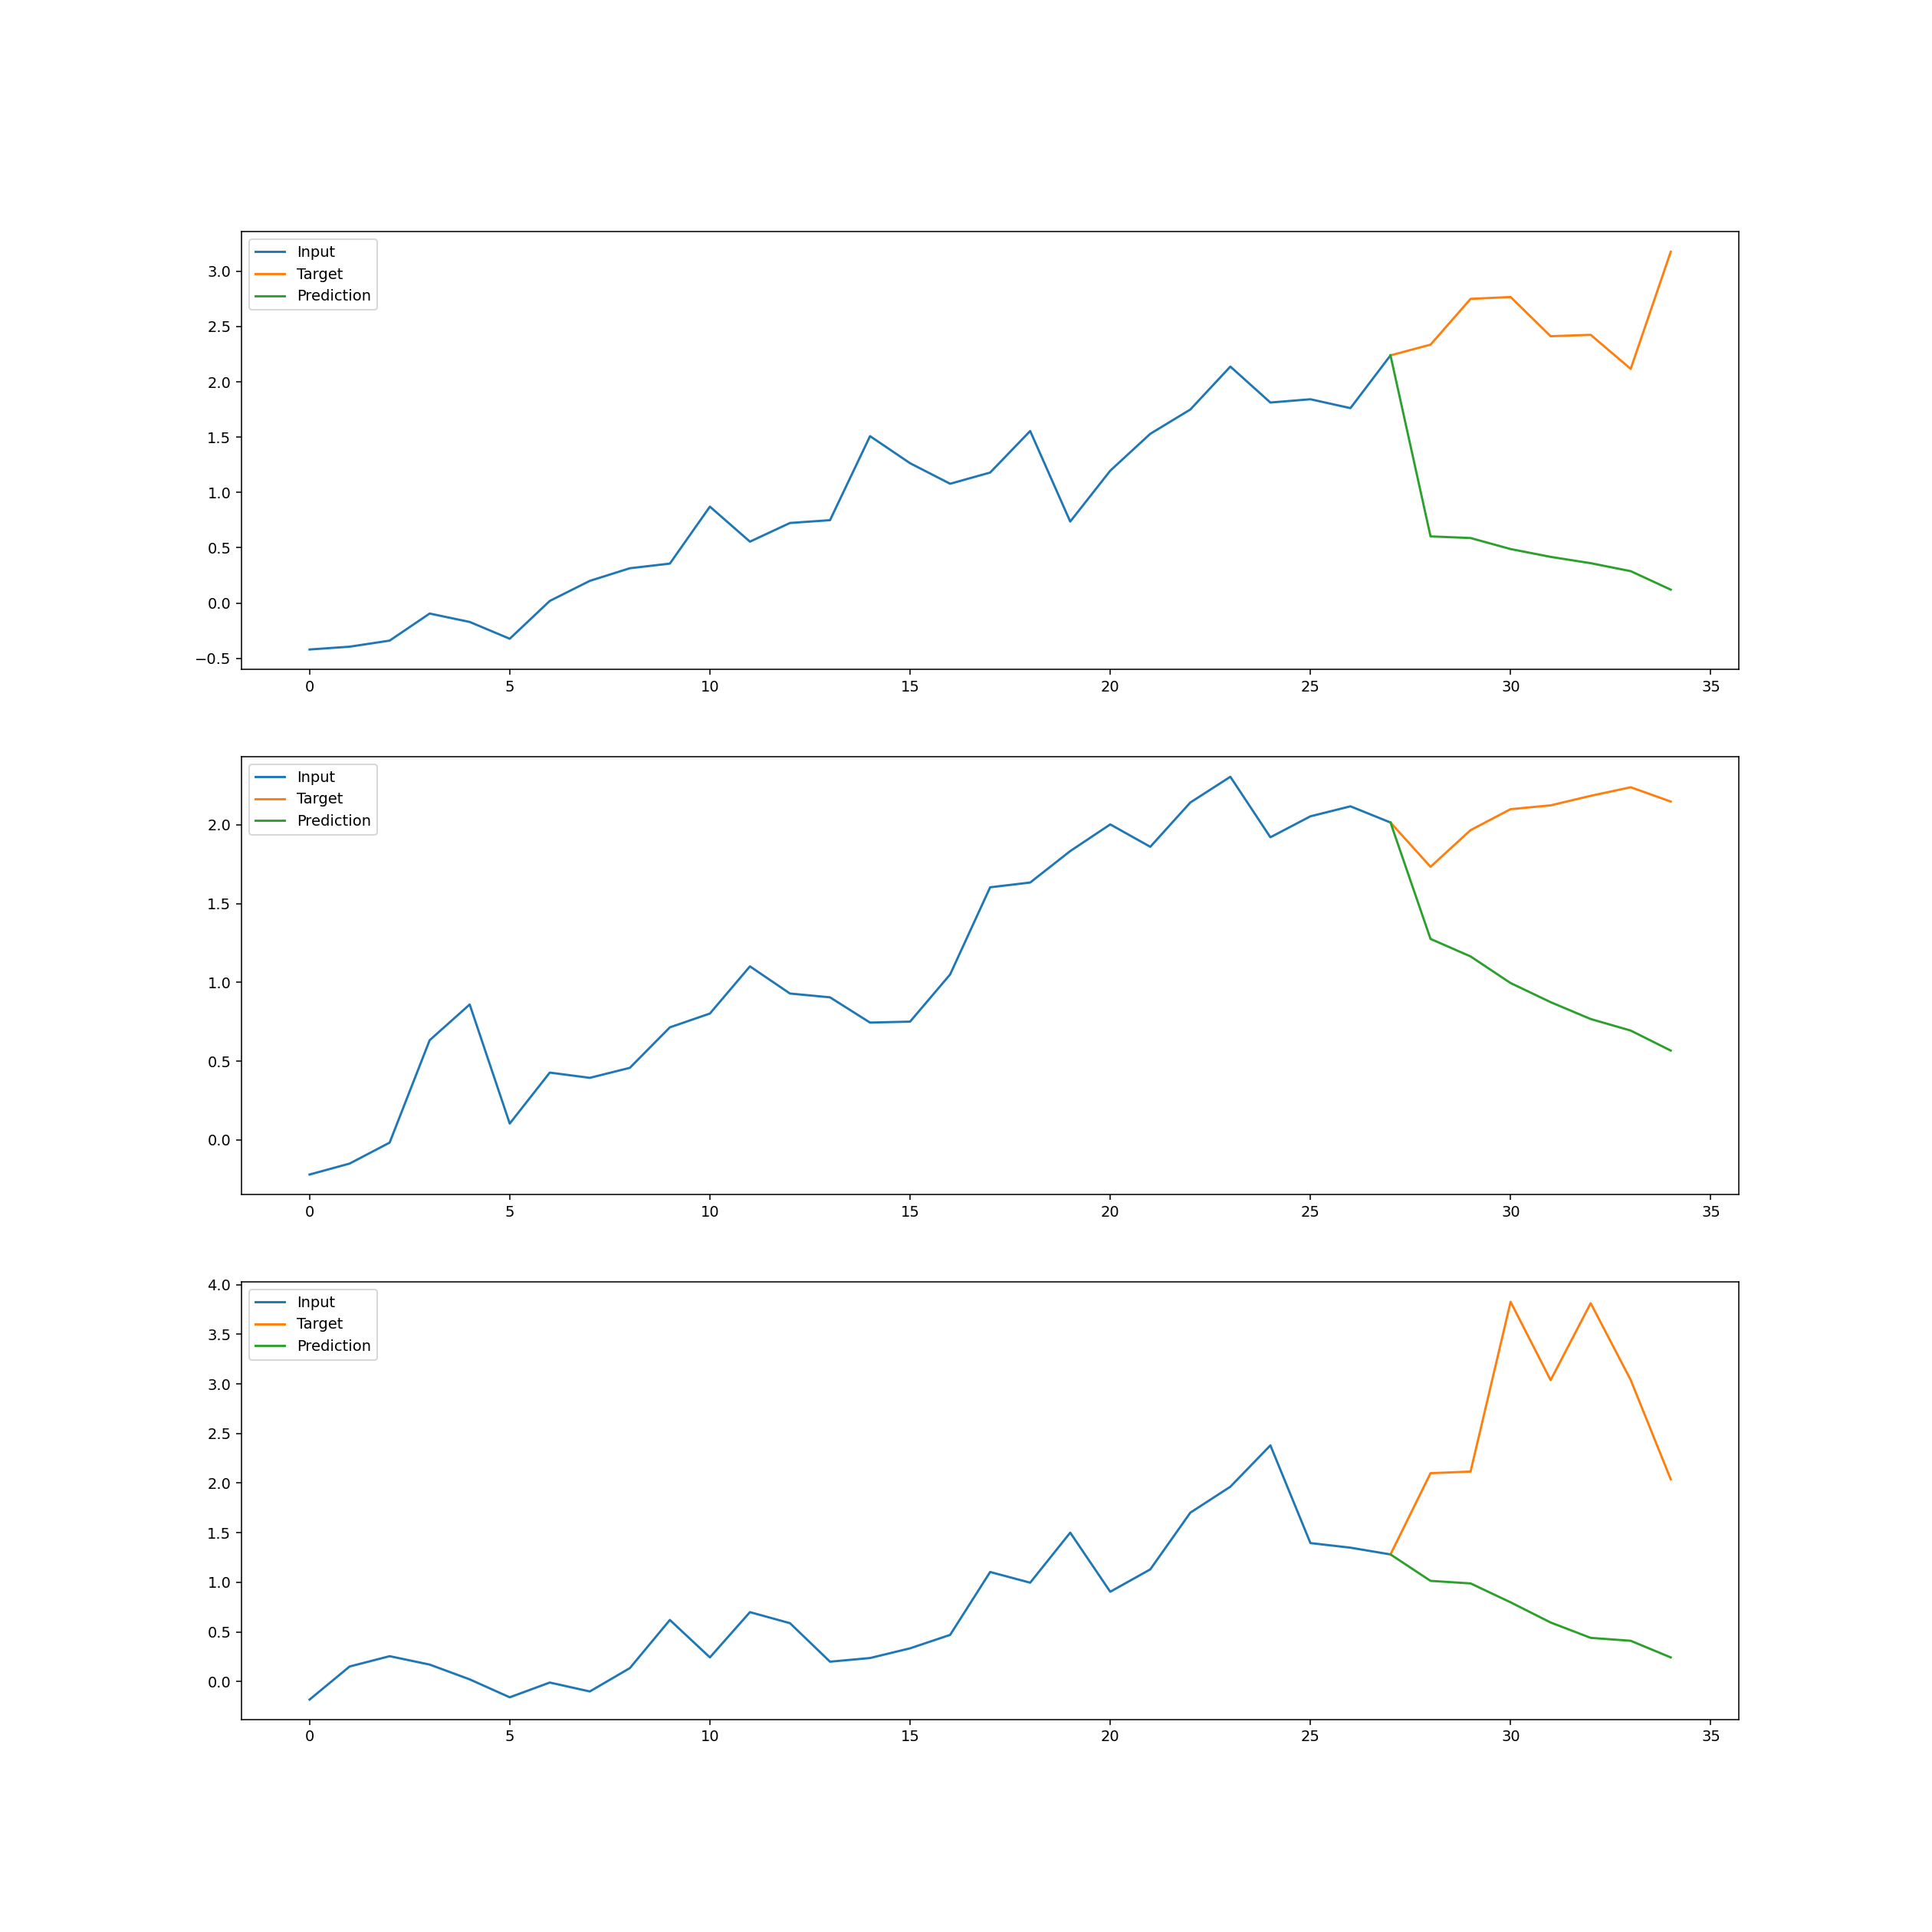

In [88]:
nrow = 3
ncol = 1

input_length = config.forecasting_module.backcast_length
output_length = config.forecasting_module.forecast_length

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18*ncol, 6*nrow), dpi=70)

for ii in range(nrow):
    axes[ii].plot(x_axis[:input_length], inputs[-1, ii, 0], label='Input')
#     axes[ii].plot(x_axis[:input_length], backcast[ii, -1], label='Backcast')

    axes[ii].plot(x_axis[input_length-1:], np.append(inputs[-1, ii, 0, -1],target[-1, ii]), label='Target')
    axes[ii].plot(x_axis[input_length-1:], np.append(inputs[-1, ii, 0, -1], pred[-1, ii]), label='Prediction')
    axes[ii].legend()

In [ ]:
nrow = 25
ncol = 1

input_length = config.forecasting_module.backcast_length
output_length = config.forecasting_module.forecast_length

name = exp.split('/')[-1].split('__')[0]

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18*ncol, 6*nrow), dpi=70)

cncat_target = target[:,:,0].swapaxes(1,0).reshape(25, -1)
cncat_pred = pred[:,:,0].swapaxes(1,0).reshape(25, -1)


start_date = pd.to_datetime('2020-03-22') ## 시작 날짜
end_date = pd.to_datetime('2020-05-03') ## 마지막 날짜
 
dates = pd.date_range(start_date,end_date,freq='D') ## 일단위로 생성

# inv_inputs = scaler.inv_scale(inputs[batch, :, 0])
inv_target = scaler.inv_scale(cncat_target)
inv_preds = scaler.inv_scale(cncat_pred)

for ii in range(nrow):
#     axes[ii].plot(x_axis[:input_length], inputs[-1, ii, 0], label='Input')
#     axes[ii].plot(x_axis[:input_length], backcast[ii, -1], label='Backcast')
    mape = MAPE(inv_target[ii], inv_preds[ii])
    axes[ii].plot(inv_target[ii], label='Target')
    axes[ii].plot(inv_preds[ii], label='Prediction')
    axes[ii].set_title(f'{country[ii]}: {mape}')
    axes[ii].legend()
    
f.savefig(f'{name}_total_prediction.png')

### Animation

In [113]:
from matplotlib.animation import FuncAnimation, PillowWriter

In [114]:
cncat_target = target[:,:,0].swapaxes(1,0).reshape(25, -1)
cncat_pred = pred[:,:,0].swapaxes(1,0).reshape(25, -1)


start_date = pd.to_datetime('2020-03-22') ## 시작 날짜
end_date = pd.to_datetime('2020-05-03') ## 마지막 날짜
 
dates = pd.date_range(start_date,end_date,freq='D') ## 일단위로 생성

# inv_inputs = scaler.inv_scale(inputs[batch, :, 0])
inv_target = scaler.inv_scale(cncat_target)
inv_preds = scaler.inv_scale(cncat_pred)

In [115]:
node = -3

In [116]:
_preds = tuple(inv_preds[node].tolist())
_targets = tuple(inv_target[node].tolist())

<IPython.core.display.Javascript object>


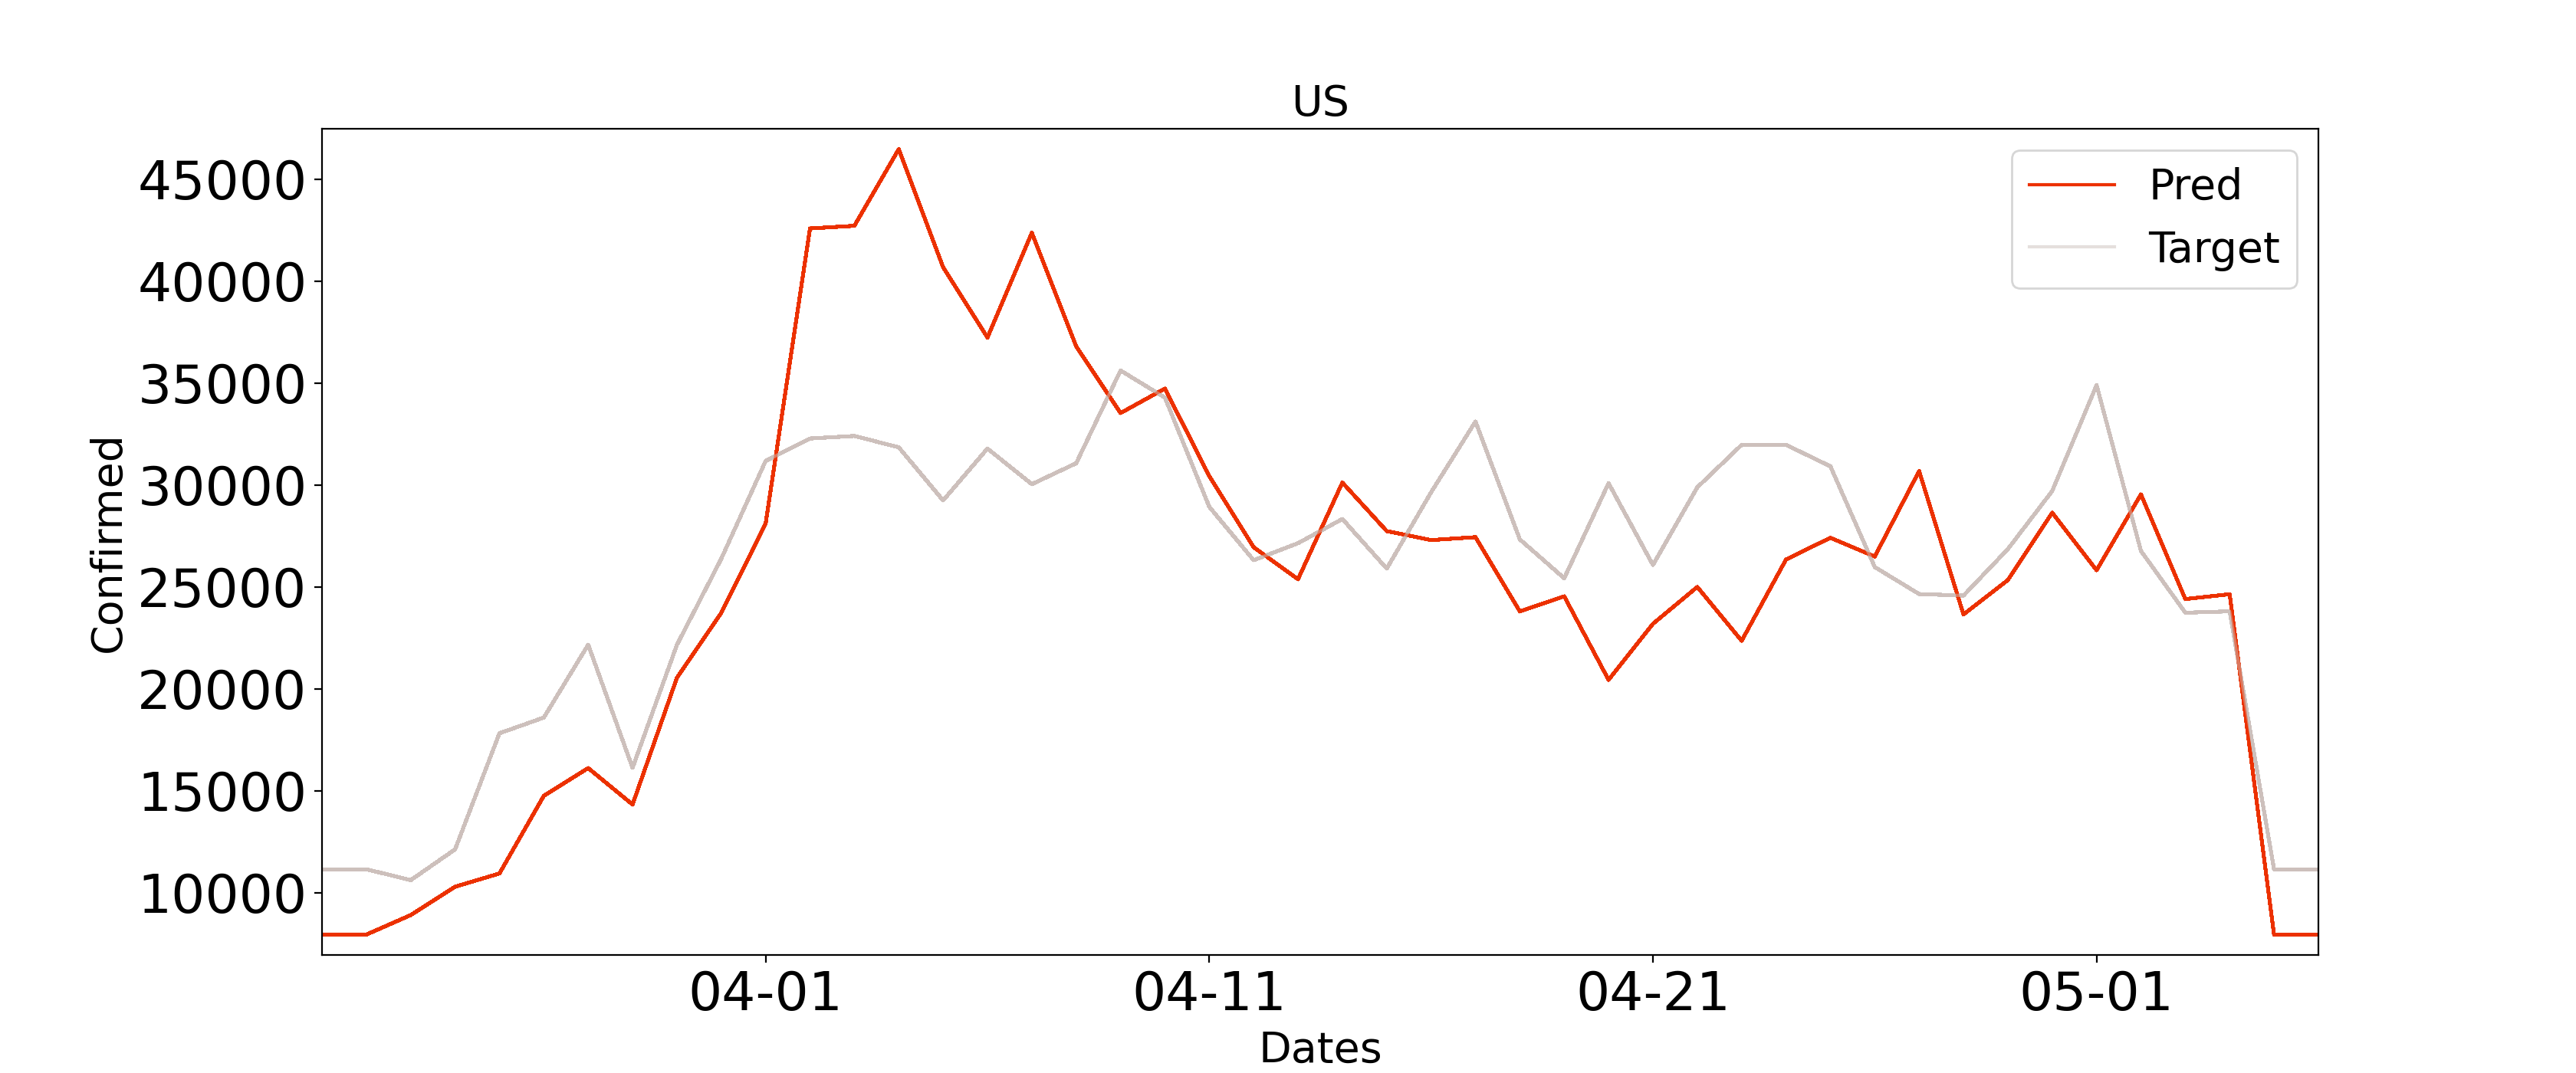

In [117]:
%matplotlib notebook

x = []
y_2 = []
y_3 = []

_preds = tuple(inv_preds[node].tolist())
_targets = tuple(inv_target[node].tolist())

y_max = max(_preds + _targets) + 1000
y_min = min(_preds + _targets) - 1000


fig, ax = plt.subplots(figsize=(16.8,7))

ax.set_xticks([10, 20, 30, 40])
ax.set_xticklabels([dates[10].strftime('%m-%d'), dates[20].strftime('%m-%d'),
                    dates[30].strftime('%m-%d'), dates[40].strftime('%m-%d')])

ax.set_xlabel('Dates', fontsize=20)
ax.set_ylabel('Confirmed', fontsize=20)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

def animate(i):        
    y_2.append(_preds[i])
    y_3.append(_targets[i])


    ax.plot(y_2, label='Pred', color='#EC3100')
    ax.plot(y_3, label='Target', color='#CDC0BC', alpha = 0.5)
        
    ax.set_xlim([0,45])
    ax.set_ylim([y_min,y_max])
    
    ax.set_xticks([10, 20, 30, 40])
    ax.set_xticklabels([dates[10].strftime('%m-%d'), dates[20].strftime('%m-%d'),
                        dates[30].strftime('%m-%d'), dates[40].strftime('%m-%d')])
    
    ax.set_xlabel('Dates', fontsize=20)
    ax.set_ylabel('Confirmed', fontsize=20)

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    
    plt.legend(['Pred', 'Target'], fontsize=20)
#     plt.legend.fontsize(30)
    plt.title('US', fontsize=20)
    
ani = FuncAnimation(fig, animate, frames=range(43), interval=50, repeat=False)
ani.save('test.gif', dpi=80, writer=PillowWriter(fps=200))

plt.show()

<IPython.core.display.Javascript object>


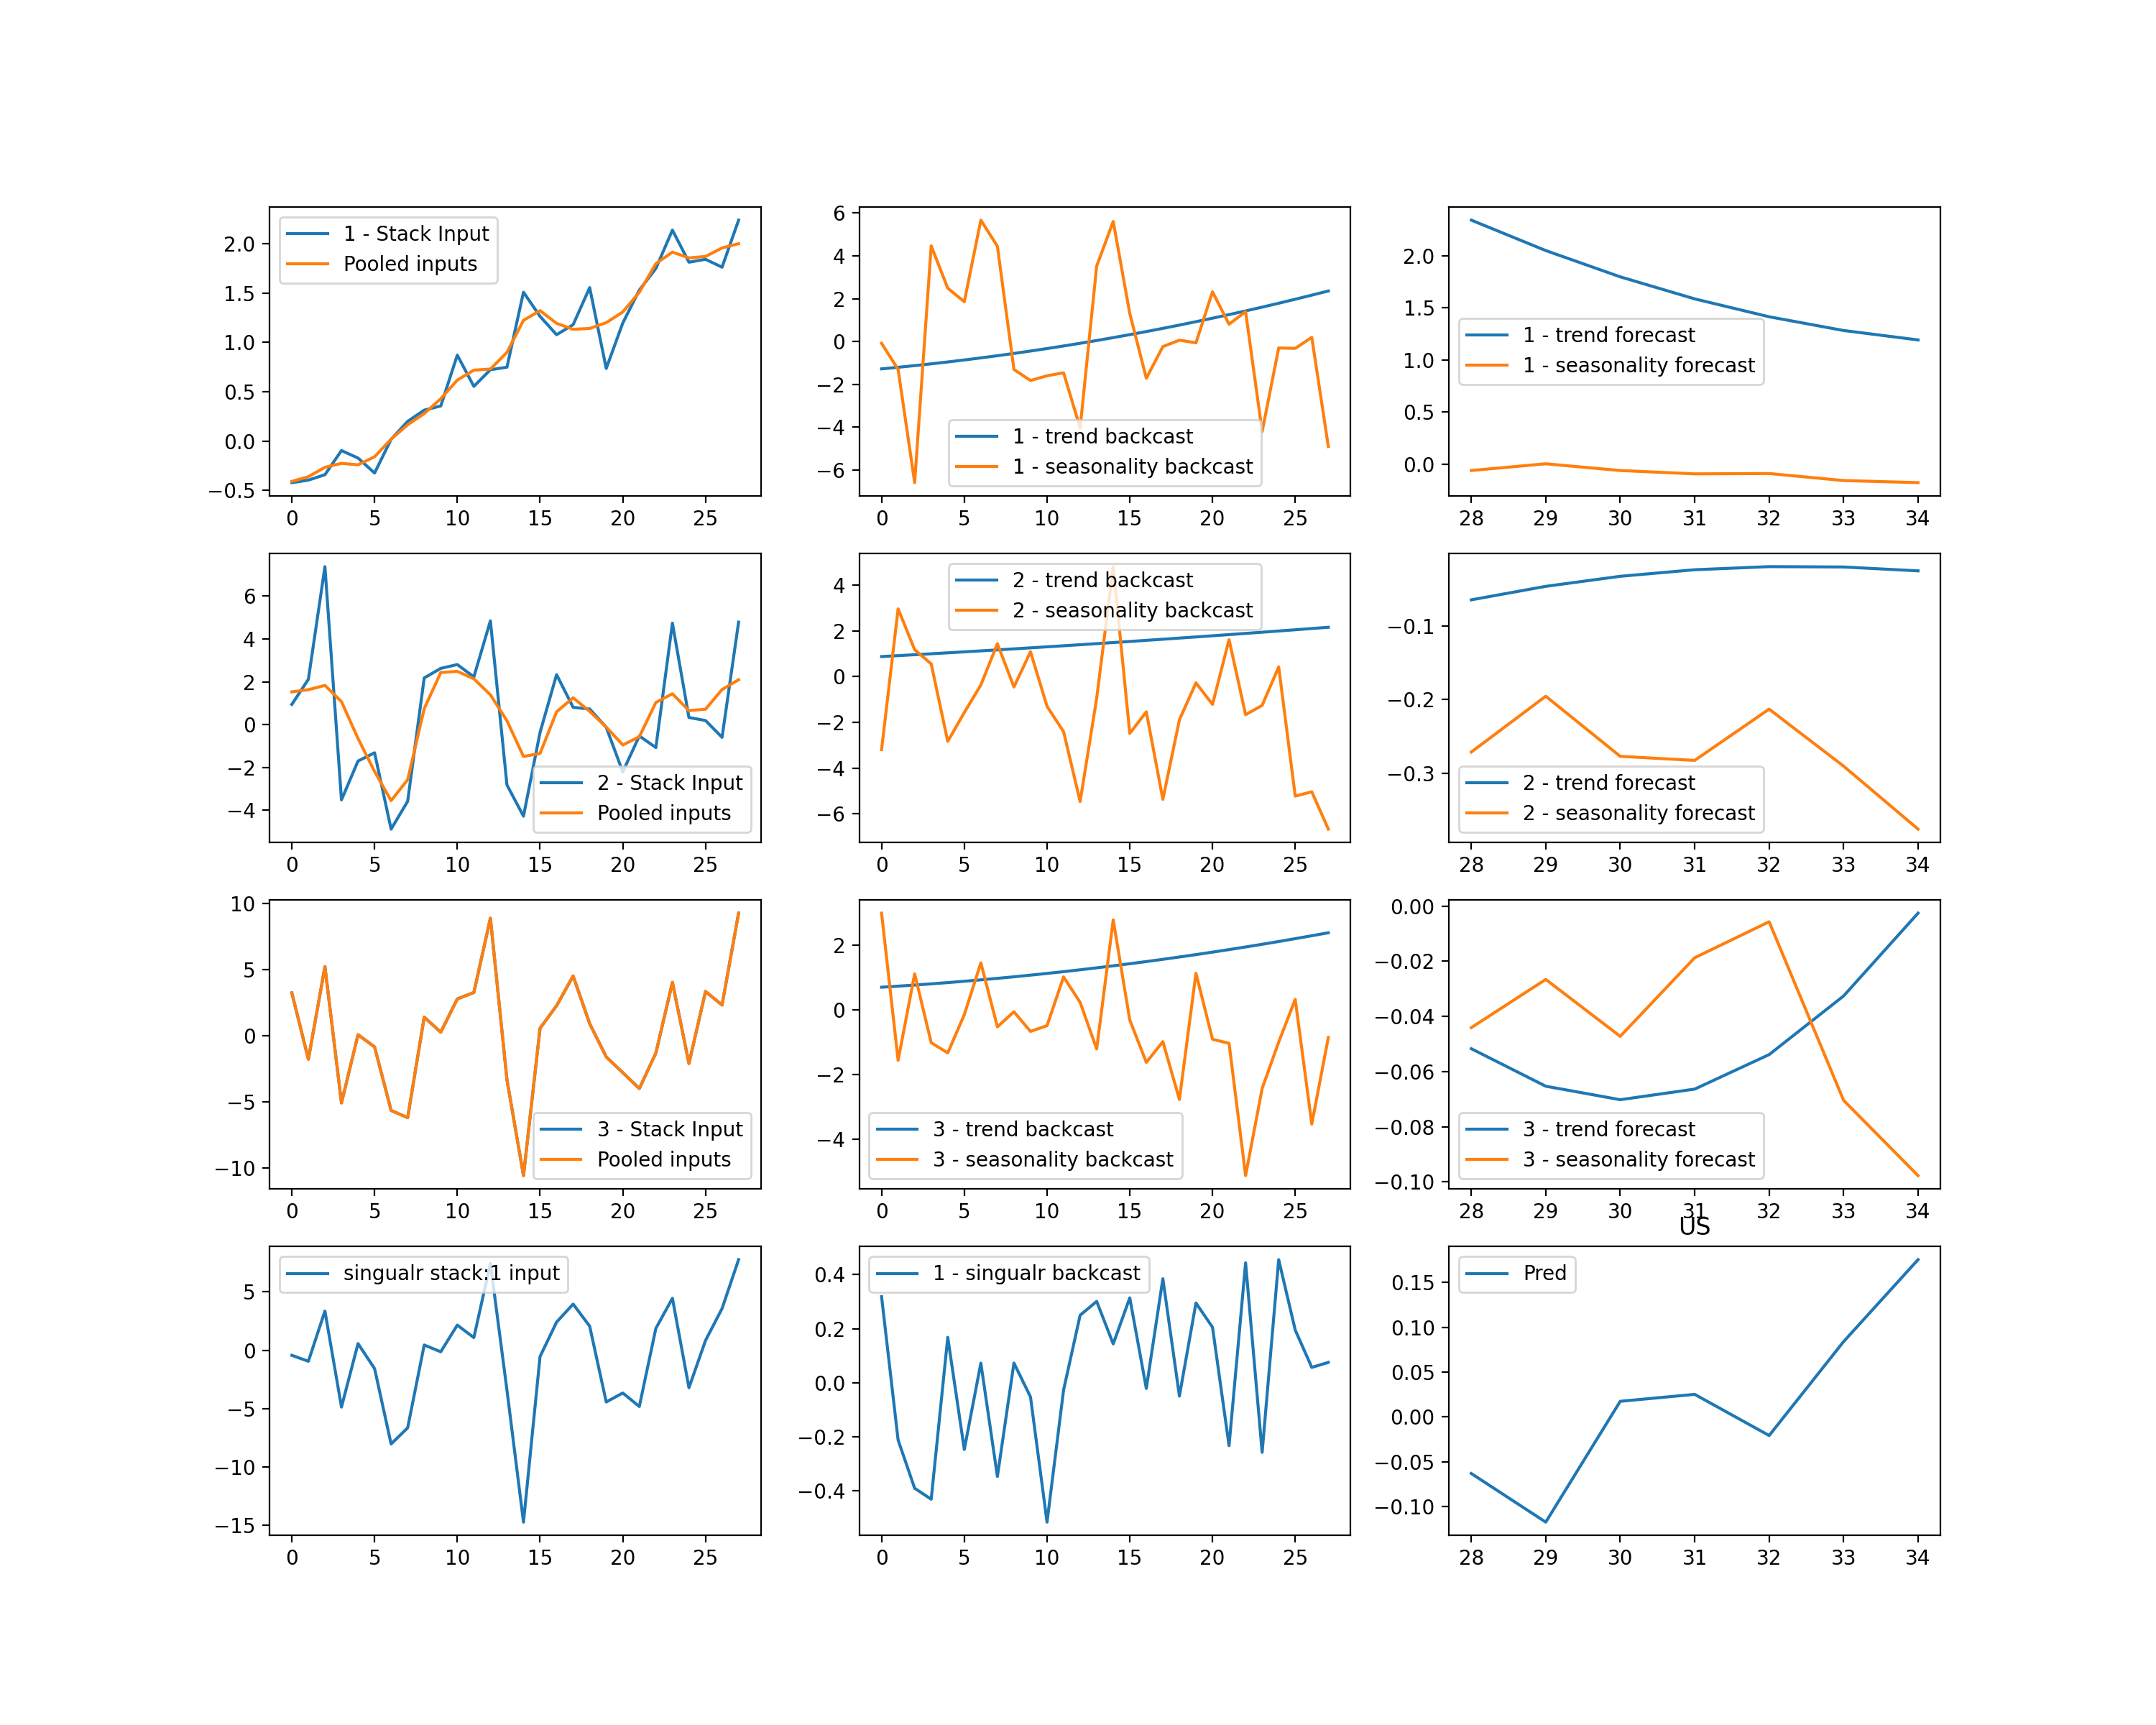

In [27]:
node = 0

nrow = per_trend_backcast.shape[1] + singual_backcast.shape[1]
ncol = 3

input_length = config.forecasting_module.backcast_length
output_length = config.forecasting_module.forecast_length

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(5*ncol, 3*nrow))

inpt = inputs[-1, node, 0]
for ii in range(per_trend_backcast.shape[1]):    
    axes[ii,0].plot(x_axis[:input_length], inpt, label=f'{ii+1} - Stack Input')
    axes[ii,0].legend()
    
    pooling_layer = nn.AvgPool1d(kernel_size=config.forecasting_module.n_pool_kernel_size[ii],
                                              stride=config.forecasting_module.n_pool_kernel_size[ii], 
                                 ceil_mode=False)
    
    pooled_inputs = pooling_layer(torch.Tensor(inpt).unsqueeze(dim=0))

    interpolate_inputs = F.interpolate(pooled_inputs.unsqueeze(dim=1), size=config.forecasting_module.backcast_length,
                                   mode='linear', align_corners=False).squeeze(dim=1)
    
    axes[ii,0].plot(x_axis[:input_length], interpolate_inputs[0], label=f'Pooled inputs')
    axes[ii,0].legend()
    
    axes[ii,1].plot(x_axis[:input_length], per_trend_backcast[-1,ii][node], label=f'{ii+1} - trend backcast')
    axes[ii,1].legend()
    
    axes[ii,1].plot(x_axis[:input_length], per_seasonality_backcast[-1, ii][node], label=f'{ii+1} - seasonality backcast')
    axes[ii,1].legend()
    
    axes[ii,2].plot(x_axis[input_length:], per_trend_forecast[-1,ii][node], label=f'{ii+1} - trend forecast')
    axes[ii,2].legend()
    
    axes[ii,2].plot(x_axis[input_length:], per_seasonality_forecast[-1, ii][node], label=f'{ii+1} - seasonality forecast')
    axes[ii,2].legend()
    
    inpt = inpt - (per_trend_backcast[-1,ii][node] + per_seasonality_backcast[-1, ii][node])
    
    
for jj in range(singual_backcast.shape[1]):
    axes[ii+jj+1,0].plot(x_axis[:input_length], inpt, label=f'singualr stack:{jj+1} input')
    axes[ii+jj+1,0].legend()
    
    axes[ii+jj+1,1].plot(x_axis[:input_length], singual_backcast[-1,jj][node], label=f'{jj+1} - singualr backcast')
    axes[ii+jj+1,1].legend()
    
    axes[ii+jj+1,2].plot(x_axis[input_length:], singual_forecast[-1,jj][node], label=f'{jj+1} - singualr forecast')
    axes[ii+jj+1,2].legend()

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=70)

axes.plot(inv_target[country.index('US')], label='Target')
axes.plot(inv_preds[country.index('US')], label='Prediction')

In [94]:
country_axis=[]
for i in range(len(country)):
    country_axis.append(f'{i}: {country[i]}')

In [95]:
learn_adj = test_result['adj_matrix'].copy()

for i in range(25):
    for j in range(25):
        if learn_adj[i,j] >= 0.03:
            learn_adj[i,j] = 1
        else:
            learn_adj[i,j] = 0

<IPython.core.display.Javascript object>


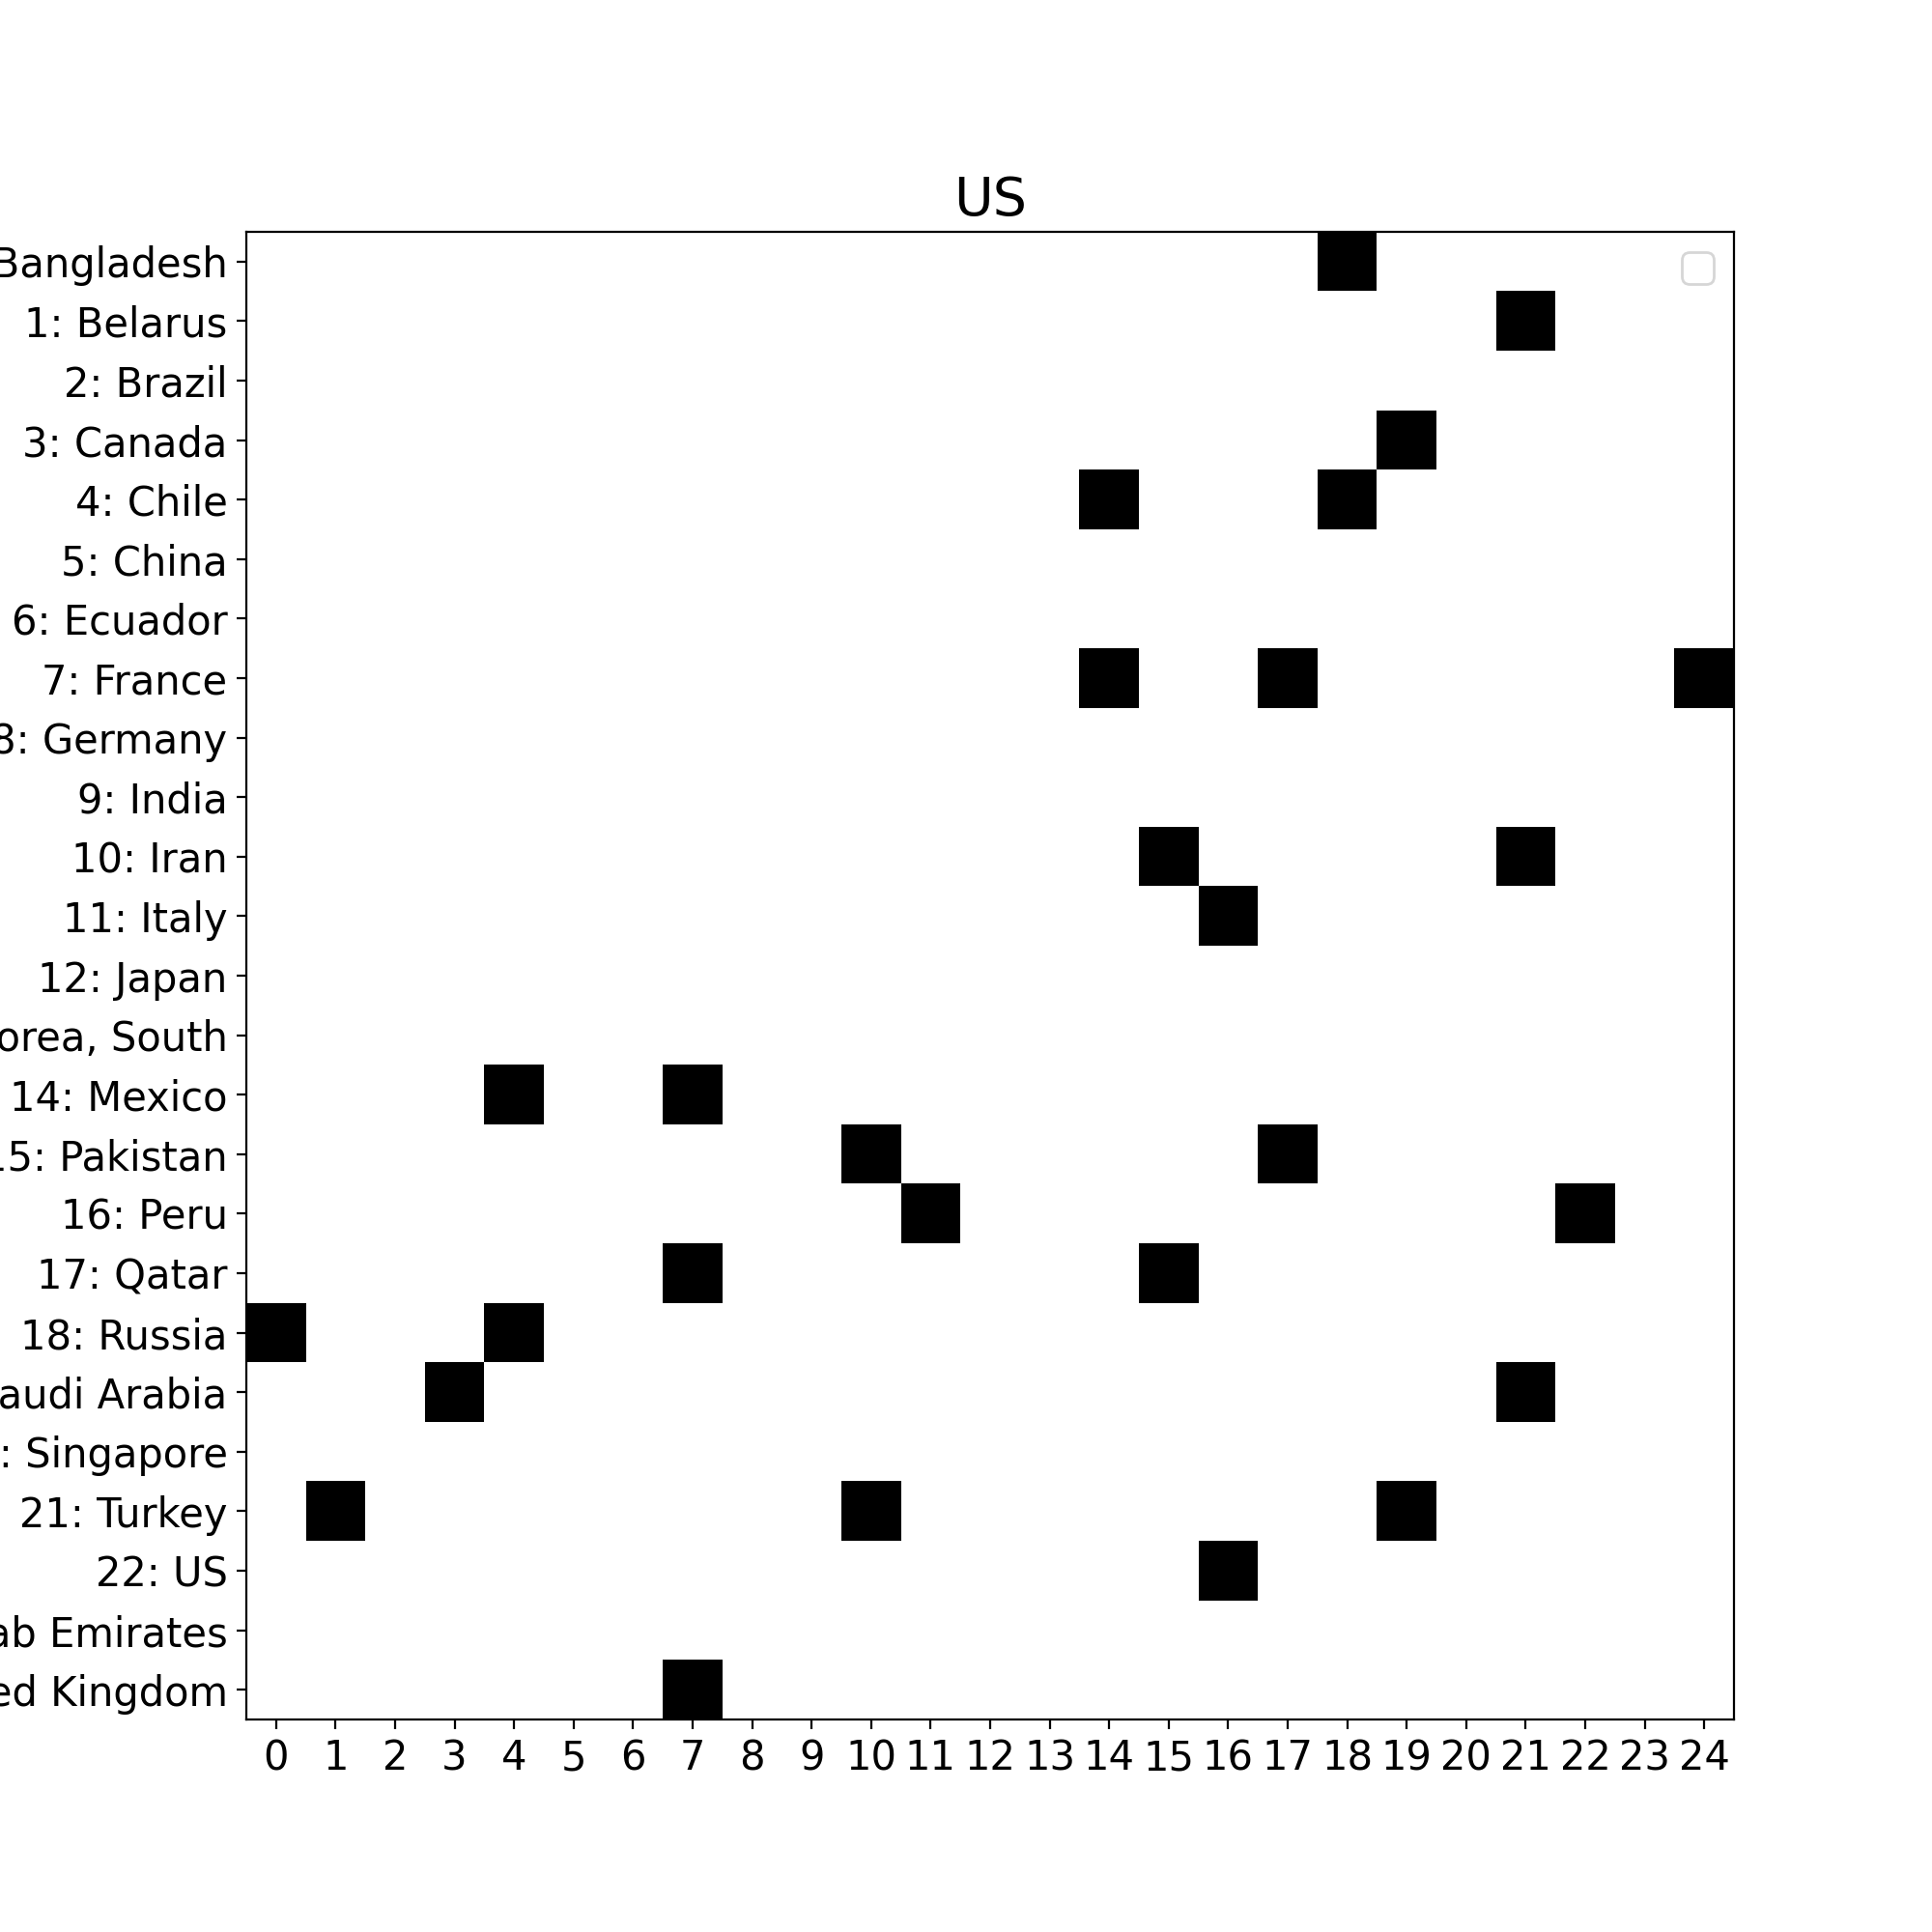

In [96]:
# learn_adj = to_dense_adj(add_self_loops(dense_to_sparse(torch.Tensor(test_result['adj_matrix']))[0])[0])[0]
# learn_adj = test_result['adj_matrix']
f, axes = plt.subplots(figsize=(10,10))

axes.imshow(learn_adj, cmap='Greys')
axes.set_xticks(np.arange(0,25).tolist())
axes.set_yticks(np.arange(0,25).tolist())

axes.set_xticklabels(np.arange(0,25).tolist())
axes.set_yticklabels(country_axis)

f.savefig(f'adj_matrix.png')
f.show()

# Map

In [97]:
import folium

In [98]:
country_lat_long_dict = {'US': [40.0, -100.0],
 'Mexico': [23.6345, -102.5528],
 'Russia': [61.52401, 105.318756],
 'Italy': [41.87194, 12.56738],
 'Germany': [51.165691, 10.451526],
 'Belarus': [53.7098, 27.9534],
 'Brazil': [-14.235, -51.9253],
 'Peru': [-9.19, -75.0152],
 'Ecuador': [-1.8312, -78.1834],
 'Chile': [-35.6751, -71.543],
 'India': [20.593684, 78.96288],
 'Turkey': [38.9637, 35.2433],
 'Saudi Arabia': [23.885942, 45.079162],
 'Pakistan': [30.3753, 69.3451],
 'Iran': [32.427908, 53.688046],
 'Singapore': [1.2833, 103.8333],
 'Qatar': [25.3548, 51.1839],
 'Bangladesh': [23.685, 90.3563],
 'United Arab Emirates': [23.424076, 53.847818],
 'Japan': [36.204824, 138.252924],
 'Korea, South': [35.907757, 127.766922],
 'Canada': [45.424721, -75.695],
 'United Kingdom': [51.509865, -0.118092],
 'France': [48.864716, 2.349014],
 'China': [39.916668, 116.383331]}

In [99]:
covid = pd.read_csv('../GSL/data/COVID19/time_series_covid19_confirmed_global.csv')

my_covid = covid[covid['Country/Region'].isin(country)].copy()
my_covid.drop('Province/State', axis=1, inplace = True)
my_covid_confimed = my_covid[my_covid.columns.tolist()[:1]+my_covid.columns.tolist()[3:]].copy()
my_covid_confimed.reset_index(drop=True, inplace=True)
temp = pd.to_datetime(my_covid.columns[3:])
my_covid_confimed.columns.values[1:] = temp
df = my_covid_confimed.groupby('Country/Region').sum().copy()
total_confirmed = df.sum(axis=1)

In [100]:
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

for cnt in country_lat_long_dict:
    folium.Circle(
        location=[country_lat_long_dict[cnt][0], country_lat_long_dict[cnt][1]],
        popup=cnt,
        radius = float(total_confirmed[cnt])/20000,
        color = 'crimson',
        fill = True,
        fill_color = 'crimson').add_to(m)

    
    temp=[]
    for ii, connect in enumerate(test_result['adj_matrix'][country.index(cnt)]):
        if connect >= 0.03:
            temp.append(country[ii])
    for conneced_country in temp:
        folium.PolyLine(locations=[country_lat_long_dict[cnt], country_lat_long_dict[conneced_country]],
                       tooltip='Polyline',
                       color = 'crimson',
                       weight=1,
                       dash_array='10').add_to(m)

m.save(f'map.html')
m

In [ ]:
import matplotlib.font_manager as fm

In [ ]:
font_list = [font.name for font in fm.fontManager.ttflist]

font_list